# Make predictions and back-test with observations 

### Author - Chris Wyburn-Powell, see the latest version on [github](https://github.com/chrisrwp/low-frequency-variability/blob/main/predict/Predict_back_test.ipynb)

**Input:**
- `HadISST1_regional_SIC_area.nc`
- `HadISST1_1920-2022_regional_lin_detend_on_1920_2014.nc`
- `HadISST1_1920-2022_regional_lowpass_filt_lin_detend_on_1920_2014.nc`
- `weights_linear_<model_name>_month_<month>_var_9_best_season_LE_all_region_Sep_lowpass_filt.nc`
- `weights_linear_CMIP6_month_<month>_var_9_best_season_LE_all_region_Sep_lowpass_filt_1920_2014.nc`
- `CVDP_standardized_linear_detrended_1920_2014_historical_<model_name>.nc`
- `CVDP_standardized_linear_detrended_1920_2014_CERA20C_ERAI_all_var.nc`
- `CVDP_standardized_linear_detrended_1920_2014_ERA20C_ERAI_all_var.nc`
- `CVDP_standardized_linear_detrended_1920_2014_HadISST_all_var.nc`
- `correlation_SIC_lagged_1_20_years_linear_detrended_1920_2014_lowpass_filt_HadISST1_for_1956_2022.nc`

**Method:**
- Read in the observational CVDP values and multiply by the LE and MMLE linear model coefficients
- Plot the predicted and observed regional SIC
- Correlate the and compare with persistence of the observed SIC

**Output:**
- `GCM_models_1956_2022_predictions_from_obs_best_LE_seasons.nc`
- `MMLE_model_1956_2022_predictions_from_obs_best_LE_seasons.nc`
- `GCMs_predict_r2_HadISST1_1976_2022_best_LE_seasons.nc`
- `MMLE_predict_r2_HadISST1_1976_2022_best_LE_seasons.nc`
- Figure 8
<br>

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
import scipy.signal as signal
import datetime

In [3]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

region_names_short = [
    'Beaufort Sea', 'Chukchi Sea', 'E. Siberian Sea', 'Laptev Sea', 'Kara Sea', 
    'Barents Sea', 'Greenland', 'Baffin', 'Canadian AA', 'Hudson', 
    'Central Arctic', 'Bering', 'Baltic', 'Okhotsk', 'Yellow', 'Cook',      
]

region_areas = [1073814076306.1292,960840854868.5659,1051884855351.1294,843492313719.2942,
                923143583990.7802,1631940838161.5251,3271215474163.032]

## 1. Get linear detrended and lowpass filtered HadISST1 regional data

In [82]:
HadISST1_mask = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/raw_data/masie_masks/masiemask_HadISST1.nc')
HadISST1_30N = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/HadISST1_30N_filled_1920-2022.nc')
HadISST1_gridarea = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/HadISST1_30N_filled_1920-2022_gridarea.nc')

In [83]:
for region_ in [1,2,3,4,5,6,11]:
    print(((HadISST1_mask['mask']==1)*HadISST1_gridarea['cell_area'].where(HadISST1_mask['regions']==region_)).sum('latitude').sum('longitude').values)

1073814076306.1292
960840854868.5659
1051884855351.1294
843492313719.2942
923143583990.7802
1631940838161.5251
3271215474163.032


In [85]:
HadISST1_30N_masked = HadISST1_30N['SIC'].where(HadISST1_mask['mask']==1)

In [86]:
region_average_SIC = []
region_area = []

for region_ in np.arange(1,17):
    region_average_SIC.append(HadISST1_30N_masked.where(
        HadISST1_mask['regions']==region_).mean('latitude').mean('longitude')*100)
    region_area.append((HadISST1_30N_masked.where(
        HadISST1_mask['regions']==region_)*HadISST1_gridarea['cell_area']).sum(
        'latitude').sum('longitude'))

In [87]:
region_area_xr = xr.concat((region_area), dim='region')
region_average_SIC_xr = xr.concat((region_average_SIC), dim='region')
region_area_xr['region'] = np.arange(1,17)
region_average_SIC_xr['region'] = np.arange(1,17)

In [14]:
#save to NetCDF
# HadISST1_regional = xr.Dataset({'area':region_area_xr, 
#                                 'SIC':region_average_SIC_xr})
# HadISST1_regional.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
#     +'HadISST1_regional_SIC_area.nc')
HadISST1_regional = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    +'HadISST1_regional_SIC_area.nc')

### Linear detrend based on 1920-2014


In [128]:
lin_detrend = {}

for var_ in ['SIC','area']: 
    lin_detrend_SIC = []
    for month_ in np.arange(1,13):
        SIC_1920_2022 = HadISST1_regional[var_].sel(
            time=HadISST1_regional['time.month']==month_)
        SIC_1920_2022 = SIC_1920_2022.rename({'time':'year'})
        SIC_1920_2022['year'] = np.arange(1920,2023)
        SIC_1920_2014 = SIC_1920_2022.sel(year=slice('1920','2014')).copy()

        lin_detrend_SIC_month = []
        for region_ in np.arange(1,17):
            SIC_coefs = np.polyfit(np.arange(1920,2015), 
                                   SIC_1920_2014.sel(region=region_), 1)
            lin_detrend_SIC_month.append(
                SIC_1920_2022.sel(region=region_) 
                - (np.arange(1920,2023)*SIC_coefs[0] + SIC_coefs[1]))

        lin_detrend_SIC.append(xr.concat((lin_detrend_SIC_month),dim='region'))

    lin_detrend_SIC_xr = xr.concat((lin_detrend_SIC), dim='month')       
    lin_detrend_SIC_xr['month'] = np.arange(1,13)
    lin_detrend[var_] = lin_detrend_SIC_xr

In [136]:
lin_detrend = xr.Dataset(lin_detrend)

lin_detrend.attrs = {
    'Description': 'Linear detrending of regional average sea ice '\
        'concentration (variable: SIC) in %, and sea ice area '\
        '(variable: area). Linear trend based on period 1920-2014 '\
        'for observational data 1920-2022 from the HadISST1 dataset. '\
        'Regions as defined for NSIDC MASIE-NH Version 1, '\
        'doi:10.7265/N5GT5K3K.',
    'Timestamp'  : str(datetime.datetime.utcnow().strftime(
        "%H:%M UTC %a %Y-%m-%d")),
    'Data source': 'HadISST1, doi:10.1029/2002JD002670',
    'Analysis'   : 'https://github.com/chrisrwp/'\
        'low-fequency-variability/tree/main/predict/Predict_back_test.ipynb',
}

lin_detrend.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    'HadISST1_1920-2022_regional_lin_detend_on_1920_2014.nc')

### Lowpass filter both the regional SIC and area anomalies

In [147]:
lowpass_filt = {}
for var_ in ['SIC','area']:
    b, a = signal.butter(5, 0.25, btype='lowpass') #low pass filter
    #apply the filter forward and backward along a given axis
    filtered = signal.filtfilt(b, a, lin_detrend[var_], axis=2) 

    lowpass_filt[var_] = (lin_detrend[var_] * 0) + filtered

In [157]:
lowpass_filt = xr.Dataset(lowpass_filt)

lowpass_filt.attrs = {
    'Description': '2-year lowpass filter of linear detrending of regional '\
        'average sea ice concentration (variable: SIC) in %, and sea ice area '\
        '(variable: area). Linear trend based on period 1920-2014 '\
        'for observational data 1920-2022 from the HadISST1 dataset. '\
        'Regions as defined for NSIDC MASIE-NH Version 1, '\
        'doi:10.7265/N5GT5K3K.',
    'Timestamp'  : str(datetime.datetime.utcnow().strftime(
        "%H:%M UTC %a %Y-%m-%d")),
    'Data source': 'HadISST1, doi:10.1029/2002JD002670',
    'Analysis'   : 'https://github.com/chrisrwp/'\
        'low-fequency-variability/tree/main/predict/Predict_back_test.ipynb',
}

lowpass_filt.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    'HadISST1_1920-2022_regional_lowpass_filt_lin_detend_on_1920_2014.nc')

In [4]:
#load the NetCDF files
lin_detrend = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    'HadISST1_1920-2022_regional_lin_detend_on_1920_2014.nc')
lowpass_filt = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    'HadISST1_1920-2022_regional_lowpass_filt_lin_detend_on_1920_2014.nc')

## 2. Load coefs from CVDP obs and LEs and MMLE 3+

In [19]:
CVDP_vars = ['AMO', 'ATN',  'NAO', 'NINO34', 'NPO', 'PDO', 'PNA',  'IPO','TAS'] 


var_extract_monthly = ['amo_timeseries_mon', 'ipo_timeseries_mon', 'nino34',
                       'pdo_timeseries_mon', 'atlantic_nino',]

var_extract_seasonally = ['npo_timeseries_', 'pna_timeseries_', 
                          'nao_timeseries_', 'tas_global_avg_']

var_dataset_names = {
    'amo_timeseries_mon':'AMO', 'ipo_timeseries_mon':'IPO',
    'nino34':'NINO34', 'pdo_timeseries_mon':'PDO', 'atlantic_nino':'ATN', 
    'npo_timeseries_':'NPO', 'pna_timeseries_':'PNA', 'nao_timeseries_':'NAO',
    'tas_global_avg_':'TAS',
}

In [20]:
#load CVDP processed myself
dir_path = '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    +'CVDP_obs_local_run/'

file_var_dict = {
    'AMO':['HadISST.cvdp_data.amo.1920-2022.nc','amo_timeseries_mon'], 
    'ATN':['HadISST.cvdp_data.sst.indices.1920-2022.nc','atlantic_nino'],
    'IPO':['HadISST.cvdp_data.ipo.1920-2022.nc','ipo_timeseries_mon'],
    'NAO':['NCEP-NCAR.cvdp_data.psl.nam_nao.1948-2022.nc','nao_timeseries_'],
    'NINO34':['HadISST.cvdp_data.sst.indices.1920-2022.nc','nino34'],
    'NPO':['NCEP-NCAR.cvdp_data.psl.pna_npo.1948-2022.nc','npo_timeseries_'],
    'PDO':['HadISST.cvdp_data.pdo.1920-2022.nc','pdo_timeseries_mon'],
    'PNA':['NCEP-NCAR.cvdp_data.psl.pna_npo.1948-2022.nc','pna_timeseries_'],
    'TAS':['GISTEMP.cvdp_data.tas.trends_timeseries.1920-2022.nc',
           'tas_global_avg_'],
}

In [21]:
CVDP_obs_dict = {}

for var_ in list(file_var_dict.keys()):
    var_name = file_var_dict[var_][1]
    
    if var_ in ['ATN','AMO','NINO34','IPO','PDO']:
        decode_bool = False
        time_replace = np.arange(np.datetime64('1920-01'),
                                 np.datetime64('2023-01'), 
                                 np.timedelta64(1, 'M')).astype(np.datetime64)
        
    #otherwise the data is seasonal with time referring to the month    
    else:        
        #1948-01, 1949-01...2022-01, 1948-04, 1949-04....2022-04.......2022-10
        time_replace = np.array([]).astype(np.datetime64)
        if var_ == 'TAS':
            start_yr = 1920
            decode_bool = False
        else:
            start_yr = 1948
            decode_bool = True
        
        for month_ in [1,4,7,10]:
            time_replace = np.append(time_replace, 
                np.arange(np.datetime64(str(start_yr)+'-{}'.format(str(month_).zfill(2))), 
                          np.datetime64('2023-{}'.format(str(month_).zfill(2))), 
                          np.timedelta64(1, 'Y')
                         ).astype(np.datetime64)
                     )       
    
    CVDP_obs = xr.open_dataset(dir_path+file_var_dict[var_][0],         
                               decode_times=decode_bool)
    
    #extract the correct variables in corect time increments
    if var_name in var_extract_monthly:
        #save the monthly variables without alteration
        CVDP_obs_dict[var_] = xr.DataArray(
            data = np.ravel(CVDP_obs[var_name].copy()),
            coords = {'time':time_replace},
            dims = ['time']
        ).sortby('time')

    elif var_name in var_extract_seasonally:

        temp_seaonal = []
        season_names = ['djf','mam','jja','son']
        for month_i, month_ in enumerate([1,4,7,10]):
            temp_seaonal.append(CVDP_obs[var_name+season_names[month_i]])
            
        CVDP_obs_dict[var_] = xr.DataArray(
            data = np.ravel(temp_seaonal),
            coords = {'time':time_replace},
            dims = ['time']
        ).sortby('time')

### Detrend and standardize the observational variables on time period of 1920-2014

In [22]:
#linear detrend vars 1920-2014
CVDP_obs_standard = {}

#group into seasons, detrend seasons
for var_ in list(file_var_dict.keys()):

    for season_i, season_month in enumerate([1,4,7,10]):
        season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]][season_i]

        if var_ in ['ATN','AMO','NINO34','IPO','PDO']:

            if season_months[0] == 12:
                cor_month = 11
            else:
                cor_month = 0

            month_0 = CVDP_obs_dict[var_].sel(time=CVDP_obs_dict[var_][
                'time.month']==season_months[0]-cor_month).sel(
                time=slice('1920','2022'))
            month_1 = CVDP_obs_dict[var_].sel(time=CVDP_obs_dict[var_][
                'time.month']==season_months[1]).sel(
                time=slice('1920','2022'))
            month_2 = CVDP_obs_dict[var_].sel(time=CVDP_obs_dict[var_][
                'time.month']==season_months[2]).sel(
                time=slice('1920','2022'))

            #take the monthly average for the season
            season_raw = (month_1 + month_0.values + month_2.values)/3

        elif var_ in ['TAS']:
            season_raw = CVDP_obs_dict[var_].sel(
                time=CVDP_obs_dict[var_]['time.month']==season_months[1])

        #linearly detrend on 1920-2014 and standardize, unless SLP EOF based
        if var_ in ['NAO', 'NPO', 'PNA']:
            det_standard = CVDP_obs_dict[var_].sel(
                time=CVDP_obs_dict[var_]['time.month']==season_months[1])
            det_standard['time'] = np.arange(1948,2023)
            
        else:
            season_coefs = np.polyfit(np.arange(1920,2015),
                                  season_raw.sel(time=slice('1920','2014')),1)

            det_standard = season_raw - (np.arange(1920,2023)*season_coefs[0] 
                                         + season_coefs[1])

            det_standard = ((det_standard - det_standard.mean('time')) 
                / det_standard.std('time'))
            
            det_standard['time'] = np.arange(1920,2023)
        
        det_standard = det_standard.rename({'time':'year'})

        CVDP_obs_standard[var_+'_'+str(season_month)] = det_standard

In [23]:
CVDP_obs_standard = xr.Dataset(CVDP_obs_standard)
# CVDP_obs_standard = CVDP_obs_standard.drop('IPO_4').drop('IPO_7').drop('IPO_10')

### Load the MMLE 3+ and LE coefs

In [12]:
GCM_LE_20 = ['ACCESS-ESM1-5', 'CESM2-LENS', 'CNRM-CM6-1', 'CanESM5',
       'EC-Earth3', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR', 'NorCPM1',]

GCM_coefs = {}
for GCM in GCM_LE_20:
    
    all_months = []
    for month_ in np.arange(1,13):
        month_GCM = xr.open_dataset(
            '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'
            f'weights_linear_{GCM}_month_{str(month_).zfill(2)}_var_9_best_'\
            'season_LE_all_region_Sep_lowpass_filt.nc'
        )
        
        all_months.append(month_GCM)
    GCM_data = xr.concat((all_months),dim='month')
    GCM_data['month'] = np.arange(1,13)
    GCM_coefs[GCM] = GCM_data


In [13]:
#load the MMLE 3+ weights
all_months = []
for month_ in np.arange(1,13):
    month_GCM = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'
        f'weights_linear_CMIP6_month_{str(month_).zfill(2)}_var_9_best_'\
        'season_LE_all_region_Sep_lowpass_filt_1920_2014.nc'
    )

    all_months.append(month_GCM)
MMLE_coefs = xr.concat((all_months),dim='month')
MMLE_coefs['month'] = np.arange(1,13)

In [99]:
#load the PI Control MMLE weights
# all_months = []
# for month_ in np.arange(1,13):
#     month_GCM = xr.open_dataset(
#         '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'
#         f'weights_linear_PI_500_first_3_mem_train_month_{str(month_).zfill(2)}'\
#         '_var_9_annual_lowpass_filt_74_year_mem.nc'
#     )

#     all_months.append(month_GCM)
# PI_coefs = xr.concat((all_months),dim='month')
# PI_coefs['month'] = np.arange(1,13)

## 3. Back test 1956-2022, predict 2023-2042, calculate r$^2$ values

In [1]:
#back test
month_ = 9
GCM_1956_2022 = []
for start_yr in np.arange(1956,2023):
    print(datetime.datetime.now(), start_yr)

    all_region_xr = []
    for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
        
        all_GCM = []
        for GCM in GCM_LE_20:
            all_modes = []
            for mode in MMLE_coefs['mode_month'].values:
                if int(mode[-1]) > month_:
                    extra_year = 1
                elif int(mode[-1]) == 0:
                    extra_year = 1
                else:
                    extra_year = 0

                all_lags = []
                for lag_ in np.arange(1,21):
                        
                    all_lags.append(GCM_coefs[GCM]['weights'].sel(
                        month=month_).sel(region=region_).sel(lag=lag_).sel(
                        mode_month=mode).values * CVDP_obs_standard[mode].sel(
                        year=start_yr-extra_year).values)

                all_modes.append(all_lags)
            all_GCM.append(np.sum(all_modes, axis=0))
        
        
        all_region_xr.append(xr.DataArray(
            data=all_GCM, 
            coords={'GCM':GCM_LE_20, 
                    'year':np.arange(start_yr+1,start_yr+1+len(all_lags))}, 
            dims=['GCM','year'])
        )

    GCM_back_test = xr.concat((all_region_xr),dim='region')
    GCM_back_test['region'] = [1,2,3,4,5,6,11]
    GCM_1956_2022.append(GCM_back_test)


In [9]:
# GCM_1956_2022_xr = xr.concat((GCM_1956_2022), dim='start_yr')
# GCM_1956_2022_xr['start_yr'] = np.arange(1956,2023,1)
# GCM_1956_2022_xr.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'GCM_models_1956_2022_predictions_from_obs_best_LE_seasons.nc')
GCM_1956_2022_xr = xr.open_dataarray(
    '/glade/work/cwpowell/low-frequency-variability/predictions/'\
    'GCM_models_1956_2022_predictions_from_obs_best_LE_seasons.nc')

In [19]:
#back test MMLE 3+
month_ = 9
MMLE_1956_2022 = []
for start_yr in np.arange(1956,2023):
    if start_yr % 10 == 0:
        print(datetime.datetime.now(), start_yr)

    all_region_xr = []
    for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
        
        all_modes = []
        for mode in MMLE_coefs['mode_month'].values:
            if int(mode[-1]) > month_:
                extra_year = 1
            elif int(mode[-1]) == 0:
                extra_year = 1
            else:
                extra_year = 0

            all_lags = []
            for lag_ in np.arange(1,21):

                all_lags.append(MMLE_coefs['weights'].sel(month=month_).sel(
                    region=region_).sel(lag=lag_).sel(mode_month=mode).values \
                * CVDP_obs_standard[mode].sel(year=start_yr-extra_year).values)

            all_modes.append(all_lags)
        
        all_region_xr.append(xr.DataArray(
            data=np.sum(all_modes, axis=0), 
            coords={'year':np.arange(start_yr+1,start_yr+1+len(all_lags))}, 
            dims=['year'])
        )

    all_region_xr = xr.concat((all_region_xr),dim='region')
    all_region_xr['region'] = [1,2,3,4,5,6,11]
    MMLE_1956_2022.append(all_region_xr)


2023-11-02 14:37:58.046341 1960
2023-11-02 14:38:26.247679 1970
2023-11-02 14:38:53.930468 1980
2023-11-02 14:39:20.969354 1990
2023-11-02 14:39:47.481603 2000
2023-11-02 14:40:14.201857 2010
2023-11-02 14:40:42.266464 2020


In [10]:
# MMLE_1956_2022_xr = xr.concat((MMLE_1956_2022),dim='start_yr')
# MMLE_1956_2022_xr['start_yr'] = np.arange(1956,2023)
# MMLE_1956_2022_xr.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'MMLE_model_1956_2022_predictions_from_obs_best_LE_seasons.nc')
MMLE_1956_2022_xr = xr.open_dataarray(
    '/glade/work/cwpowell/low-frequency-variability/predictions/'\
    'MMLE_model_1956_2022_predictions_from_obs_best_LE_seasons.nc')

In [18]:
#now do the same for the PI Control MMLE 
# month_ = 9
# PI_1956_2022 = []
# for start_yr in np.arange(1956,2023):
#     if start_yr % 10 == 0:
#         print(datetime.datetime.now(), start_yr)

#     all_region_xr = []
#     for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
        
#         all_modes = []
#         for mode in list(CVDP_obs_standard.var()):
#             if int(mode[-1]) > month_:
#                 extra_year = 1
#             elif int(mode[-1]) == 0:
#                 extra_year = 1
#             else:
#                 extra_year = 0

#             all_lags = []
#             for lag_ in np.arange(1,21):

#                 all_lags.append(PI_coefs['weights'].sel(month=month_).sel(
#                     region=region_).sel(lag=lag_).sel(mode_month=mode).values \
#                 * CVDP_obs_standard[mode].sel(year=start_yr-extra_year).values)

#             all_modes.append(all_lags)
        
#         all_region_xr.append(xr.DataArray(
#             data=np.sum(all_modes, axis=0), 
#             coords={'year':np.arange(start_yr+1,start_yr+1+len(all_lags))}, 
#             dims=['year'])
#         )

#     all_region_xr = xr.concat((all_region_xr),dim='region')
#     all_region_xr['region'] = [1,2,3,4,5,6,11]
#     PI_1956_2022.append(all_region_xr)


2023-05-19 11:13:41.514718 1960
2023-05-19 11:14:38.071912 1970
2023-05-19 11:15:33.611777 1980
2023-05-19 11:16:29.764250 1990
2023-05-19 11:17:26.620140 2000
2023-05-19 11:18:23.586614 2010
2023-05-19 11:19:19.832506 2020


In [19]:
# PI_1956_2022_xr = xr.concat((PI_1956_2022),dim='start_yr')
# PI_1956_2022_xr['start_yr'] = np.arange(1956,2023)
# PI_1956_2022_xr.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'PI_model_1956_2022_predictions_from_obs.nc')
# MMLE_1956_2022_xr = xr.open_dataarray(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'PI_model_1956_2022_predictions_from_obs.nc')

### Now do calculations for the pan-Arctic

In [15]:
pan_Arctic_Sep = HadISST1_regional.sel(time=HadISST1_regional['time.month']==9)['area'].sum('region')
pan_Arctic_Sep_coefs = np.polyfit(np.arange(1920,2015), pan_Arctic_Sep.sel(time=slice('1920','2014')),1)

b, a = signal.butter(5, 0.25, btype='lowpass') #low pass filter
filtered = signal.filtfilt(b, a, pan_Arctic_Sep, axis=0) 
pan_Arctic_Sep_lowpass = (pan_Arctic_Sep * 0) + filtered

In [19]:
MMLE_pan_predict = []
for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    MMLE_pan_predict.append((MMLE_1956_2022_xr.sel(start_yr=2022).sel(
        year=slice('2023','2042')).sel(region=region_) * region_areas[region_i])
                           )
    
MMLE_pan_predict = xr.concat((MMLE_pan_predict),dim='region').sum('region')

In [20]:
GCM_pan_predict = {}
for GCM_ in GCM_LE_20:
    GCM_single_pan_predict = []
    for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
        GCM_single_pan_predict.append((GCM_1956_2022_xr.sel(GCM=GCM_).sel(
            start_yr=2022).sel(year=slice('2023','2042')).sel(region=region_) 
                                       * region_areas[region_i])
                               )
    GCM_pan_predict[GCM_] = xr.concat((GCM_single_pan_predict),
                                      dim='region').sum('region')
    

In [21]:
#running n-year lagged predictions
MMLE_all_predict = []

for lag_ in np.arange(1,21):
    MMLE_all_start_yr_predict = []
    for start_yr_ in np.arange(1956,2023):
        MMLE_regions_all_predict = []
        for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
            MMLE_regions_all_predict.append((MMLE_1956_2022_xr.sel(
                start_yr=start_yr_).sel(
                year=start_yr_+lag_).sel(
                region=region_) * region_areas[region_i]))

        MMLE_all_start_yr_predict.append(xr.concat((MMLE_regions_all_predict),
                                          dim='region'))
        
    MMLE_all_predict.append(xr.concat((MMLE_all_start_yr_predict),
                                          dim='start_yr'))

MMLE_all_predict = xr.concat((MMLE_all_predict),dim='lag')
MMLE_all_predict['lag'] = np.arange(1,21)

In [21]:
#compute predictions for the PI Control MMLE 
# PI_all_predict = []

# for lag_ in np.arange(1,21):
#     MMLE_all_start_yr_predict = []
#     for start_yr_ in np.arange(1956,2023):
#         MMLE_regions_all_predict = []
#         for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
#             MMLE_regions_all_predict.append((PI_1956_2022_xr.sel(
#                 start_yr=start_yr_).sel(
#                 year=start_yr_+lag_).sel(
#                 region=region_) * region_areas[region_i]))

#         MMLE_all_start_yr_predict.append(xr.concat((MMLE_regions_all_predict),
#                                           dim='region'))
        
#     PI_all_predict.append(xr.concat((MMLE_all_start_yr_predict),
#                                           dim='start_yr'))

# PI_all_predict = xr.concat((PI_all_predict),dim='lag')
# PI_all_predict['lag'] = np.arange(1,21)

## 4. Calculate the r2 values of the predictions

In [26]:
#compute the r2 values for all the GCMs
month_ = 9
all_cor_GCM = {}
for GCM_ in GCM_1956_2022_xr['GCM'].values: 
    
    all_cor_LE_regions = []
    for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
        
        all_cor_LE_lags = []
        for lag_ in np.arange(1,21):
            
            sequential = []
            for start_yr_ in np.arange(1976,2023):
                sequential.append(GCM_1956_2022_xr.sel(
                    start_yr=start_yr_).sel(year=start_yr_+lag_).sel(
                    region=region_).sel(GCM=GCM_))
            sequential = xr.concat((sequential),dim='year')*100
            
            HadISST_use = lowpass_filt['SIC'].sel(region=region_).sel(
                    month=month_).sel(year=slice(str(1976+lag_),'2022'))
            
            all_cor_LE_lags.append(
                np.corrcoef(HadISST_use, sequential[:-lag_])[0][1])
            
        all_cor_LE_regions.append(all_cor_LE_lags)
        
    all_cor_GCM[GCM_] = xr.DataArray(
        data=all_cor_LE_regions, 
        coords={'region':[1,2,3,4,5,6,11], 'year':np.arange(1,21)}, 
        dims=['region','year']
    )

In [23]:
# all_cor_GCM_xr = xr.Dataset(all_cor_GCM)
# all_cor_GCM_xr.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'GCMs_predict_r2_HadISST1_1976_2022_best_LE_seasons.nc')
all_cor_GCM_xr = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/predictions/'\
    'GCMs_predict_r2_HadISST1_1976_2022_best_LE_seasons.nc')

In [28]:
#compute the r2 values for the MMLE 
month_ = 9
all_cor_LE_regions = []
for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    print(datetime.datetime.now(), region_)

    all_cor_LE_lags = []
    for lag_ in np.arange(1,21):
        
        sequential = []
        for start_yr_ in np.arange(1976,2023):
            sequential.append(MMLE_1956_2022_xr.sel(
                start_yr=start_yr_).sel(year=start_yr_+lag_).sel(
                region=region_))
        sequential = xr.concat((sequential),dim='year')*100

        HadISST_use = lowpass_filt['SIC'].sel(region=region_).sel(
                month=month_).sel(year=slice(str(1976+lag_),'2022'))

        all_cor_LE_lags.append(
            np.corrcoef(HadISST_use, sequential[:-lag_])[0][1])

    all_cor_LE_regions.append(all_cor_LE_lags)
        
all_cor_MMLE_xr = xr.DataArray(
        data=all_cor_LE_regions, 
        coords={'region':[1,2,3,4,5,6,11], 'year':np.arange(1,21)}, 
        dims=['region','year']
)

2023-11-02 14:46:33.204335 1
2023-11-02 14:46:34.699939 2
2023-11-02 14:46:36.187898 3
2023-11-02 14:46:37.682642 4
2023-11-02 14:46:39.173983 5
2023-11-02 14:46:40.664966 6
2023-11-02 14:46:42.153488 11


In [35]:
# all_cor_MMLE_xr.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'MMLE_predict_r2_HadISST1_1976_2022_best_LE_seasons.nc')
all_cor_MMLE_xr = xr.open_dataarray(
    '/glade/work/cwpowell/low-frequency-variability/predictions/'\
    'MMLE_predict_r2_HadISST1_1976_2022_best_LE_seasons.nc')

In [22]:
#compute r2 values for the PI Control
# month_ = 9
# all_cor_LE_regions = []
# for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
#     print(datetime.datetime.now(), region_)

#     all_cor_LE_lags = []
#     for lag_ in np.arange(1,21):
        
#         sequential = []
#         for start_yr_ in np.arange(1976,2023):
#             sequential.append(PI_1956_2022_xr.sel(
#                 start_yr=start_yr_).sel(year=start_yr_+lag_).sel(
#                 region=region_))
#         sequential = xr.concat((sequential),dim='year')*100

#         HadISST_use = lowpass_filt['SIC'].sel(region=region_).sel(
#                 month=month_).sel(year=slice(str(1976+lag_),'2022'))

#         all_cor_LE_lags.append(
#             np.corrcoef(HadISST_use, sequential[:-lag_])[0][1])

#     all_cor_LE_regions.append(all_cor_LE_lags)
        
# all_cor_PI_xr = xr.DataArray(
#         data=all_cor_LE_regions, 
#         coords={'region':[1,2,3,4,5,6,11], 'year':np.arange(1,21)}, 
#         dims=['region','year']
# )

2023-05-19 11:23:20.180877 1
2023-05-19 11:23:21.285435 2
2023-05-19 11:23:22.353301 3
2023-05-19 11:23:23.491630 4
2023-05-19 11:23:24.687377 5
2023-05-19 11:23:25.881920 6
2023-05-19 11:23:26.950584 11


In [24]:
# all_cor_PI_xr.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'PI_predict_r2_HadISST1_1976_2022.nc')
# all_cor_PI_xr = xr.open_dataarray(
#     '/glade/work/cwpowell/low-frequency-variability/predictions/'\
#     'PI_predict_r2_HadISST1_1976_2022.nc')

In [25]:
#compute r2 for pan-Arctic for all GCMs
month_ = 9
cor_GCM_pan = []
for GCM_ in GCM_1956_2022_xr['GCM'].values:         
    
    all_cor_LE_lags = []
    for lag_ in np.arange(1,21):
        
        sequential = []
        for start_yr_ in np.arange(1976,2023):
            sequential.append((GCM_1956_2022_xr.sel(
                start_yr=start_yr_).sel(year=start_yr_+lag_).sel(
                GCM=GCM_)*region_areas).sum('region'))
        sequential = xr.concat((sequential),dim='year')*100

        HadISST_use = lowpass_filt['area'].sum('region').sel(
            month=month_).sel(year=slice(str(1976+lag_),'2022'))

        all_cor_LE_lags.append(
            np.corrcoef(HadISST_use, sequential[:-lag_])[0][1])

    cor_GCM_pan.append(xr.DataArray(
        data=all_cor_LE_lags, 
        coords={'year':np.arange(1,21)}, 
        dims=['year']
    ))
    
cor_GCM_pan = xr.concat((cor_GCM_pan),dim='GCM')
cor_GCM_pan['GCM'] = GCM_1956_2022_xr['GCM'].values

In [26]:
#compute r2 for pan-Arctic for the MMLE
month_ = 9

cor_MMLE_pan = []   
for lag_ in np.arange(1,21):

    sequential = []
    for start_yr_ in np.arange(1976,2023):
        sequential.append((MMLE_1956_2022_xr.sel(
            start_yr=start_yr_).sel(year=start_yr_+lag_)*region_areas).sum(
            'region'))
    sequential = xr.concat((sequential),dim='year')*100

    HadISST_use = lowpass_filt['area'].sum('region').sel(
        month=month_).sel(year=slice(str(1976+lag_),'2022'))

    cor_MMLE_pan.append(
        np.corrcoef(HadISST_use, sequential[:-lag_])[0][1])

In [27]:
#compute the pan-Arctic persistence 
month_ = 9

cor_obs_pan = []   
for lag_ in np.arange(1,21):
    
    HadISST_init = lowpass_filt['area'].sum('region').sel(
        month=month_).sel(year=slice('1976',str(2022-lag_)))
    
    HadISST_end = lowpass_filt['area'].sum('region').sel(
        month=month_).sel(year=slice(str(1976+lag_),'2022'))

    cor_obs_pan.append(
        np.corrcoef(HadISST_init, HadISST_end)[0][1])

In [28]:
#load obs persistnce r2
obs_corr = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'\
    'correlation_SIC_lagged_1_20_years_linear_detrended_1920_2014_lowpass_'
    'filt_HadISST1_for_1956_2022.nc'
)

## 5. Figure 8 

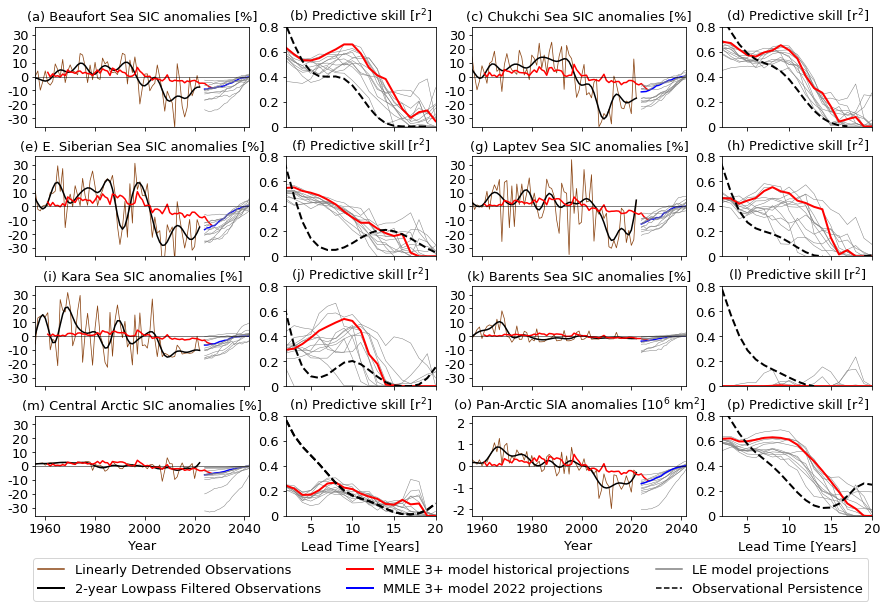

In [52]:
month_ = 9
letter_list = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']

fig = plt.figure(figsize=[15,9])
gs = GridSpec(4, 4, width_ratios=[1, 0.7, 1, 0.7], height_ratios=[1, 1,1,1])

axes = []
for i in range(16):
    axes.append(fig.add_subplot(gs[i]))

#plot the regional SIC anomalies: linear detrend, lowpass, MMLE predicted
for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    
    #linearly detrended SIC anomalies
    axes[region_i*2].plot(
        np.arange(1920,2023), lin_detrend['SIC'].sel(month=month_).sel(
        region=region_), c='saddlebrown', linewidth=0.75)
    
    #lowpass filtered SIC anomalies
    axes[region_i*2].plot(
        np.arange(1920,2023), lowpass_filt['SIC'].sel(month=month_).sel(
        region=region_), c='k')
    
    axes[region_i*2].plot(np.arange(1961,2028), MMLE_all_predict.sel(
        region=region_).sel(lag=5)/region_areas[region_i]*100, c='r')
    
    axes[region_i*2].plot(np.arange(2024,2043), 
        MMLE_1956_2022_xr.sel(region=region_).sel(start_yr=2022).sel(
            year=slice('2024','2042'))*100, c='b')
    
    for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
        axes[region_i*2].plot(
            np.arange(2024,2043), GCM_1956_2022_xr.sel(start_yr=start_yr_).sel(
            region=region_).sel(GCM=GCM_).sel(year=slice('2024','2042'))*100, 
            c='0.5', linewidth=0.5)  
    
        
    axes[region_i*2].axhline(0, c='k', linewidth=0.5)
    axes[region_i*2].set_ylim(-36,36)
    axes[region_i*2].set_xlim(1956,2042)
    if region_ < 11:
        axes[region_i*2].set_xticklabels([])
    axes[region_i*2].set_title('('+letter_list[region_i*2]+') '
        +region_names_short[region_-1]+' SIC anomalies [%]', fontsize=13)
    
    
    ###plot the r2 values and persistence
    for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
        GCM_r2 = all_cor_GCM_xr[GCM_].sel(region=region_)
        axes[(region_i*2)+1].plot(
            np.arange(1,21), GCM_r2.where(GCM_r2>0,0)**2, c='0.5',
            linewidth=0.5)
        
    MMLE_r2 = all_cor_MMLE_xr.sel(region=region_)
    axes[(region_i*2)+1].plot(np.arange(1,21), 
                              MMLE_r2.where(MMLE_r2>0,0)**2, c='r', linewidth=2)
        
    #persistence
    obs_r = obs_corr['r_value'].sel(region=region_).sel(month=month_)
    axes[(region_i*2)+1].plot(np.arange(1,21), obs_r.where(obs_r>0)**2,
                              c='k', linestyle='--', linewidth=2)
        
    axes[(region_i*2)+1].set_ylim(0,0.8)
    axes[(region_i*2)+1].set_xlim(2,20)
    axes[(region_i*2)+1].set_title('('+letter_list[(region_i*2)+1]+') '
                                   +r'Predictive skill [r$^2$]', fontsize=13)
    if region_ < 11:
        axes[(region_i*2)+1].set_xticklabels([])
    
    
####### PAN-ARCTIC PLOTS #######
# axes[14].plot(np.arange(1920,2023), pan_Arctic_Sep/1e12, c='saddlebrown', 
#               linewidth=0.75)
# axes[14].plot(np.arange(1920,2043), 
#               (((np.arange(1920,2043)*pan_Arctic_Sep_coefs[0])
#                + pan_Arctic_Sep_coefs[1]))/1e12, c='0.5', linestyle='--')
# axes[14].plot(np.arange(1920,2023), pan_Arctic_Sep_lowpass/1e12, c='k')

# axes[14].plot(np.arange(1958,2025), 
#               (((np.arange(1958,2025)*pan_Arctic_Sep_coefs[0])
#                + pan_Arctic_Sep_coefs[1]))/1e12 
#               + MMLE_all_predict.sum('region').sel(lag=2)/1e12, c='r')

# for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
#     axes[14].plot(
#         np.arange(2024,2043), (((np.arange(2024,2043)*pan_Arctic_Sep_coefs[0])
#         + pan_Arctic_Sep_coefs[1]))/1e12 + GCM_pan_predict[GCM_][1:]/1e12, 
#         c='0.5', linewidth=0.5)  
    
# axes[14].plot(np.arange(2024,2043), 
#               (((np.arange(2024,2043)*pan_Arctic_Sep_coefs[0])
#                + pan_Arctic_Sep_coefs[1]))/1e12 
#               + MMLE_pan_predict[1:]/1e12, c='b')


axes[14].plot(np.arange(1920,2023), pan_Arctic_Sep/1e12 - (
    ((np.arange(1920,2023)*pan_Arctic_Sep_coefs[0])
     + pan_Arctic_Sep_coefs[1]))/1e12, c='saddlebrown', linewidth=0.75)

axes[14].plot(np.arange(1920,2023), pan_Arctic_Sep_lowpass/1e12  - (
    ((np.arange(1920,2023)*pan_Arctic_Sep_coefs[0])
     + pan_Arctic_Sep_coefs[1]))/1e12, c='k')

axes[14].plot(np.arange(1961,2028), 
              MMLE_all_predict.sum('region').sel(lag=5)/1e12, c='r')

for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
    axes[14].plot(np.arange(2024,2043), GCM_pan_predict[GCM_][1:]/1e12, 
                  c='0.5', linewidth=0.5)  
    
axes[14].plot(np.arange(2024,2043), MMLE_pan_predict[1:]/1e12, c='b')

axes[14].axhline(0, c='k', linewidth=0.5)
axes[14].set_title('(o) Pan-Arctic SIA anomalies [10$^6$ km$^2$]', fontsize=13)
axes[14].set_xlim(1956,2042)
axes[14].set_ylim(-2.3,2.3)


###plot the r2 values and persistence
for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
    axes[15].plot(
        np.arange(1,21), cor_GCM_pan.sel(GCM=GCM_).where(
            cor_GCM_pan.sel(GCM=GCM_)>0,0)**2, c='0.5', linewidth=0.5)

axes[15].plot(np.arange(1,21), np.where(np.array(cor_MMLE_pan)>0,cor_MMLE_pan,0)**2, 
              c='r', linewidth=2)

axes[15].plot(np.arange(1,21), np.where(np.array(cor_obs_pan)>0,cor_obs_pan,0)**2, 
              c='k', linewidth=2, linestyle='--')


#persistence
obs_r = obs_corr['r_value'].sel(region=region_).sel(month=month_)
axes[(region_i*2)+1].plot(np.arange(1,21), obs_r.where(obs_r>0)**2,
                          c='k', linestyle='--', linewidth=2)

axes[15].set_ylim(0,0.8)
axes[15].set_xlim(2,20)
axes[15].set_title(r'(p) Predictive skill [r$^2$]', fontsize=13)

############################ ADD AXES DECORATIONS ##############################
for ax_i in [12,14]:
    axes[ax_i].set_xlabel('Year', fontsize=13)
    axes[ax_i].set_xticks([1960,1980,2000,2020,2040])
    axes[ax_i].set_xticklabels(['1960','1980','2000','2020','2040'],
                               fontsize=13)

for ax_i in [13,15]:
    axes[ax_i].set_xlabel('Lead Time [Years]', fontsize=13)
    axes[ax_i].set_xticks([5,10,15,20])
    axes[ax_i].set_xticklabels(['5','10','15','20'], fontsize=13)
    
for ax_i in np.arange(0,13,2):
    axes[ax_i].set_yticks([-30,-20,-10,0,10,20,30])
    axes[ax_i].set_yticklabels(['-30','-20','-10','0','10','20','30'],
                               fontsize=13)
    
for ax_i in np.arange(1,16,2):
    axes[ax_i].set_yticks([0,0.2,0.4,0.6,0.8])
    axes[ax_i].set_yticklabels(['0','0.2','0.4','0.6','0.8'], fontsize=13)
    
axes[14].set_yticks([-2,-1,0,1,2])
axes[14].set_yticklabels(['-2','-1','0','1','2'], fontsize=13);
    
legend_elements = [
    Line2D([0,0],[0,0], color='saddlebrown', 
           label='Linearly Detrended Observations'),
    Line2D([0,0],[0,0], color='k', 
           label='2-year Lowpass Filtered Observations', linewidth=2),
    Line2D([0,0],[0,0], color='r', 
           label='MMLE 3+ model historical projections', linewidth=2),
    Line2D([0,0],[0,0], color='b', 
           label='MMLE 3+ model 2022 projections', linewidth=2),
    Line2D([0,0],[0,0], color='0.5', label='LE model projections'),
    Line2D([0,0],[0,0], color='k', linestyle='--',
           label='Observational Persistence'),
] 

           
extra_legend = plt.legend(
    handles=legend_elements, bbox_to_anchor=(-4.6, -0.85), loc='lower left',
    borderaxespad=0., ncol=3, fontsize=13)

fig.subplots_adjust(wspace=0.2, hspace=0.3)

fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/Fig_8a_'\
            +'September_lag_5_predictive_skill_best_LE_seasons.pdf',
            bbox_inches='tight')

## Produce a larger single plot 

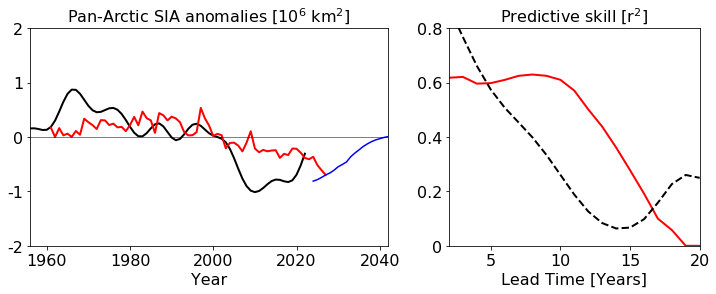

In [57]:
month_ = 9
letter_list = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']

fig = plt.figure(figsize=[12,4])
gs = GridSpec(1, 2, width_ratios=[1, 0.7])

axes = []
for i in range(2):
    axes.append(fig.add_subplot(gs[i]))

axes[0].plot(np.arange(1920,2023), pan_Arctic_Sep_lowpass/1e12  - (
    ((np.arange(1920,2023)*pan_Arctic_Sep_coefs[0])
     + pan_Arctic_Sep_coefs[1]))/1e12, c='k', linewidth=2)

axes[0].plot(np.arange(1961,2028), 
              MMLE_all_predict.sum('region').sel(lag=5)/1e12, c='r', linewidth=2)

# for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
#     axes[0].plot(np.arange(2024,2043), GCM_pan_predict[GCM_][1:]/1e12, 
#                   c='0.5', linewidth=0.5)  
    
axes[0].plot(np.arange(2024,2043), MMLE_pan_predict[1:]/1e12, c='b')

axes[0].axhline(0, c='k', linewidth=0.5)
axes[0].set_title('Pan-Arctic SIA anomalies [10$^6$ km$^2$]', fontsize=16)
axes[0].set_xlim(1956,2042)
axes[0].set_ylim(-1.3,1)

axes[0].set_yticks([-2,-1,0,1,2])
axes[0].set_yticklabels(['-2','-1','0','1','2'], fontsize=16);

axes[0].set_xlabel('Year', fontsize=16)
axes[0].set_xticks([1960,1980,2000,2020,2040])
axes[0].set_xticklabels(['1960','1980','2000','2020','2040'],
                               fontsize=16)


###plot the r2 values and persistence
# for GCM_i, GCM_ in enumerate(list(all_cor_GCM_xr.var())):
#     axes[1].plot(
#         np.arange(1,21), cor_GCM_pan.sel(GCM=GCM_).where(
#             cor_GCM_pan.sel(GCM=GCM_)>0,0)**2, c='0.5', linewidth=0.5)

axes[1].plot(np.arange(1,21), np.where(np.array(cor_MMLE_pan)>0,cor_MMLE_pan,0)**2, 
              c='r', linewidth=2)

axes[1].plot(np.arange(1,21), np.where(np.array(cor_obs_pan)>0,cor_obs_pan,0)**2, 
              c='k', linewidth=2, linestyle='--')

axes[1].set_ylim(0,0.8)
axes[1].set_xlim(2,20)
axes[1].set_title(r'Predictive skill [r$^2$]', fontsize=16);
axes[1].set_yticks([0,0.2,0.4,0.6,0.8])
axes[1].set_yticklabels(['0','0.2','0.4','0.6','0.8'], fontsize=16);

axes[1].set_xlabel('Lead Time [Years]', fontsize=16)
axes[1].set_xticks([5,10,15,20])
axes[1].set_xticklabels(['5','10','15','20'], fontsize=16);
fig.savefig('/glade/work/cwpowell/Dev/Defense_pan-Arctic_prediction_future.png', dpi=200, bbox_inches='tight')

## 6. Plot the contributions of each mode of variability

In [39]:
num_str_season = {'1':'DJF','4':'MAM','7':'JJA','0':'SON'}

CVDP_mode_readable = ['AMO', 'ATN', 'IPO', 'NAO', 'NINO34', 'NPO', 'PDO', 'PNA',
                      'TAS']

region_names_short_trunc = np.append(region_names_short[:6],region_names_short[10])

In [52]:
np.sort(MMLE_coefs['mode_month'].values)

array(['AMO_1', 'ATN_4', 'IPO_4', 'NAO_1', 'NINO34_1', 'NPO_4', 'PDO_4',
       'PNA_4', 'TAS_7'], dtype=object)

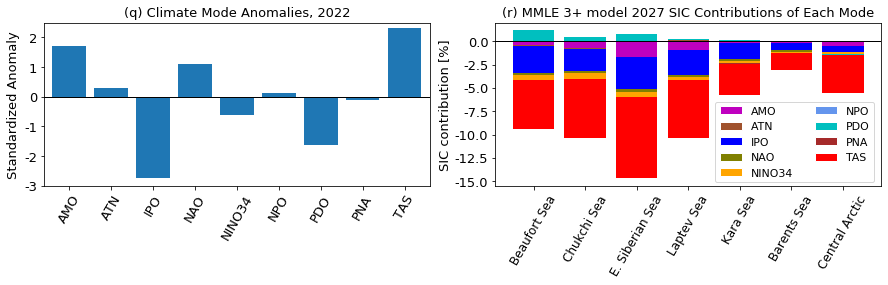

In [65]:
month_ = 9
lag_ = 5
var_colors = ['m', 'sienna','b','olive','orange','cornflowerblue','c','brown',
              'r']
fig, axes = plt.subplots(1,2, figsize=[15,3])

CVDP_bar_vals = []
mode_MMLE_cont = []
for var_ in np.sort(MMLE_coefs['mode_month'].values):
    
    if var_[-2:] in ['_1','_4','_7']:#< month_:
        extra_year = 0
    else:
        extra_year = 1

    CVDP_val = CVDP_obs_standard[var_].sel(year=2022-extra_year)
    CVDP_bar_vals.append(CVDP_val)

    all_regions = []
    for region_ in [1,2,3,4,5,6,11]:
        all_regions.append(MMLE_coefs['weights'].sel(month=month_).sel(
            mode_month=var_).sel(region=region_).sel(lag=lag_) * CVDP_val)
            
    mode_MMLE_cont.append(all_regions)
    
axes[0].bar(np.arange(1,10), CVDP_bar_vals, color='tab:blue')
axes[0].axhline(0, c='k', linewidth=1)

axes[0].set_xlim(0.4,9.6)
axes[0].set_ylim(-3,2.5)
axes[0].set_xticks(np.arange(1,10));
axes[0].set_xticklabels(np.sort(CVDP_mode_readable), rotation=60,
                        fontsize=13);
axes[0].set_yticks([-3,-2,-1,0,1,2]);
axes[0].set_yticklabels(['-3','-2','-1','0','1','2'], fontsize=13);
axes[0].set_ylabel('Standardized Anomaly', fontsize=13);
axes[0].set_title('(q) Climate Mode Anomalies, 2022', fontsize=13);
            
for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    running_total_pos = 0
    running_total_neg = 0
    for var_i, var_ in enumerate(np.sort(MMLE_coefs['mode_month'].values)):
        data = mode_MMLE_cont[var_i][region_i]*100

        if data > 0:
            axes[1].bar(region_i, data, bottom=running_total_pos,
                color=var_colors[var_i])
            running_total_pos += data
        else:
            axes[1].bar(region_i, data, bottom=running_total_neg,
                color=var_colors[var_i])
            running_total_neg += data
            
axes[1].axhline(0, c='k', linewidth=1)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(region_names_short_trunc, rotation=60, fontsize=12);
axes[1].set_yticks(np.arange(-15,1,2.5));
axes[1].set_yticklabels(['-15.0','-12.5','-10.0','-7.5','-5.0','-2.5','0.0'], 
                        fontsize=13);
axes[1].set_ylabel('SIC contribution [%]', fontsize=13);
axes[1].set_title('(r) MMLE 3+ model 2027 SIC Contributions of Each Mode', 
                  fontsize=13);

legend_elements = []
for var_i, var_ in enumerate(CVDP_vars):
    legend_elements.append(
        Patch(facecolor=var_colors[var_i], ec='1', 
              label=np.sort(CVDP_mode_readable)[var_i])
    )

extra_legend = plt.legend(
    handles=legend_elements, bbox_to_anchor=(0.57, 0.02), loc='lower left',
    borderaxespad=0., ncol=2, fontsize=11)

fig.subplots_adjust(wspace=0.17)

fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/Fig_8b_'\
            +'September_best_LE_seasons.pdf', bbox_inches='tight')